# Using Google API to analyse entity-based sentiment

In [1]:
import pandas as pd
bel_data = pd.read_csv('/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/bel_entity.csv')

In [2]:
bbc_data = pd.read_csv("/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/bbc_entity.csv")

In [12]:
from google.cloud import language_v1
import pandas as pd
import os
from google.oauth2 import service_account

# Set up credentials (update with your actual file path)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = ""
credentials = service_account.Credentials.from_service_account_file("/Users/miraslavats/Desktop/entity-sentiment-450700-b2f24ddff1bd.json")

# Initialize Google Cloud NLP client
client = language_v1.LanguageServiceClient(credentials=credentials)

def analyze_entity_sentiment(text):
    """
    Analyzes entity sentiment for a given text using Google Cloud NLP.
    Returns a list of entities with their sentiment scores and salience.
    """
    if not text.strip():
        return []

    document = language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT, language="en")
    response = client.analyze_entity_sentiment(request={"document": document, "encoding_type": language_v1.EncodingType.UTF8})
    
    entity_data = []
    for entity in response.entities:
        entity_data.append({
            "Entity": entity.name,
            "Type": language_v1.Entity.Type(entity.type_).name,
            "Sentiment Score": entity.sentiment.score,  # Ranges from -1 (negative) to +1 (positive)
            "Sentiment Magnitude": entity.sentiment.magnitude,  # Indicates strength of sentiment
            "Salience": entity.salience  # Measures importance of the entity in the text (0-1)
        })
    
    return entity_data

# Applying the function to BBC and Belarusian media datasets
bel_data["Entity_Sentiment"] = bel_data["Processed_Chunks"].apply(analyze_entity_sentiment)

In [33]:
len(bbc_data), len(bel_data)

(2023, 4901)

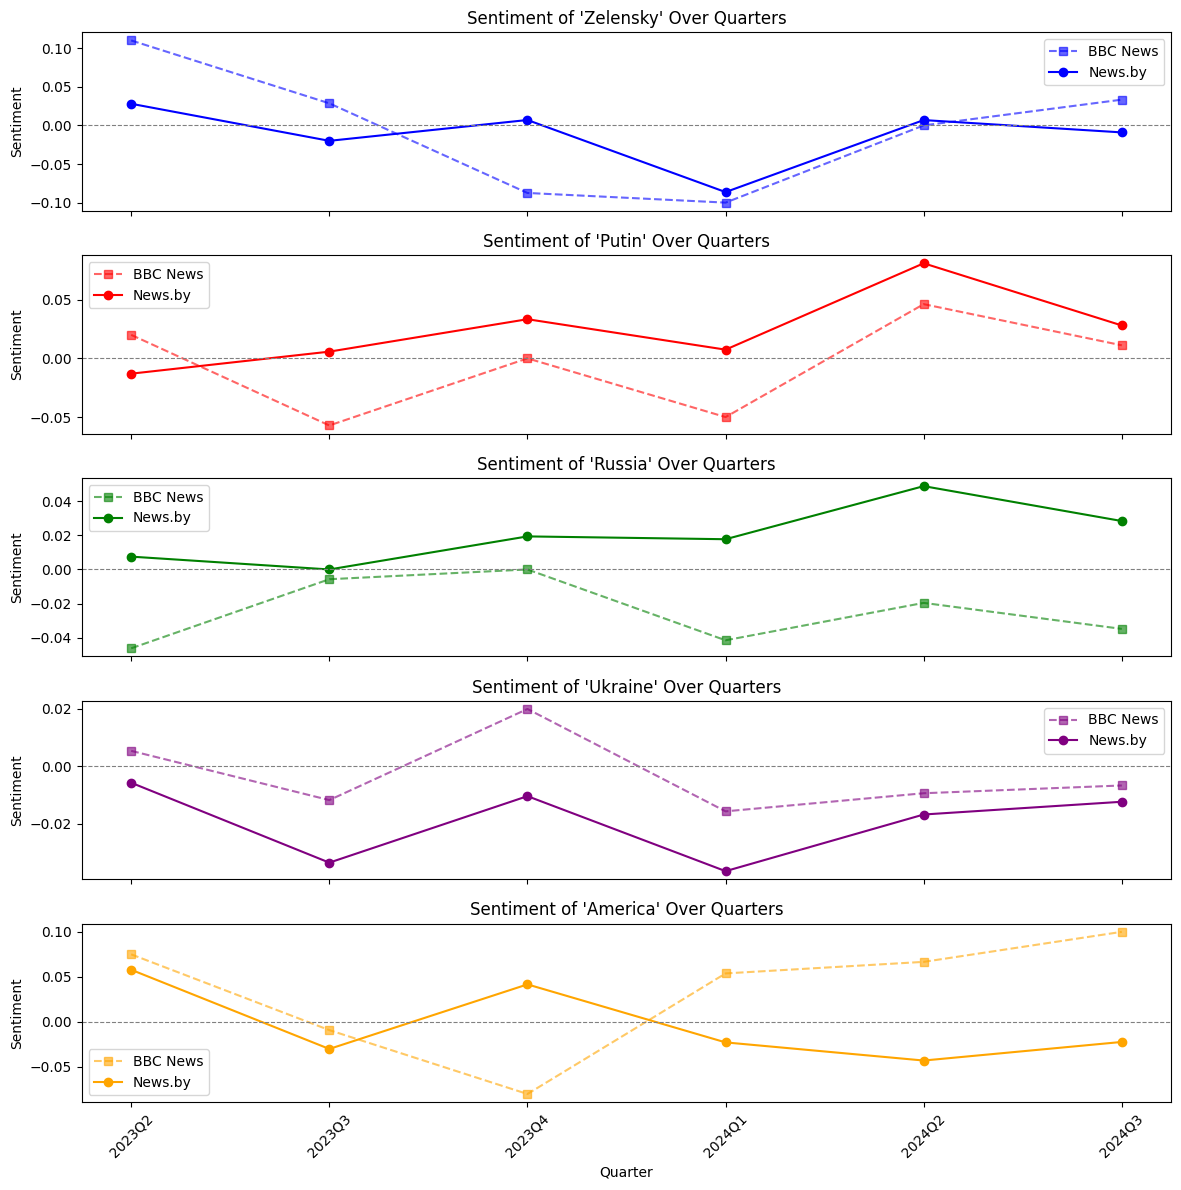

In [40]:
import ast
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

def extract_entity_sentiment(df, entity_name):
    """
    Extracts sentiment scores for a given entity over time from a DataFrame.
    """
    sentiments = []
    for idx, row in df.iterrows():
        # Convert the string to a Python object if necessary.
        entity_sentiment = row["Entity_Sentiment"]
        if isinstance(entity_sentiment, str):
            entity_sentiment = ast.literal_eval(entity_sentiment)
            
        for entity in entity_sentiment:
            if entity["Entity"] == entity_name:
                sentiments.append({"Date": row["Date"], "Sentiment": entity["Sentiment Score"]})
    
    return pd.DataFrame(sentiments)

# Defining the entities for plotting
entities = ["Zelensky", "Putin", "Russia", "Ukraine", "America"]
colors = ["blue", "red", "green", "purple", "orange"]

fig, axes = plt.subplots(len(entities), 1, figsize=(12, 12), sharex=True)

for ax, entity, color in zip(axes, entities, colors):
    # Extract sentiment data for BBC and Bel_data
    bbc_sentiment = extract_entity_sentiment(bbc_data, entity)
    belarus_sentiment = extract_entity_sentiment(bel_data, entity)

    # Converting data to datetime
    bbc_sentiment["Date"] = pd.to_datetime(bbc_sentiment["Date"])
    belarus_sentiment["Date"] = pd.to_datetime(belarus_sentiment["Date"])

    # Create a Quarter column from Date
    bbc_sentiment["Quarter"] = bbc_sentiment["Date"].dt.to_period("Q").astype(str)
    belarus_sentiment["Quarter"] = belarus_sentiment["Date"].dt.to_period("Q").astype(str)
    
    # Grouping by Quarter and calculating the mean sentiment
    bbc_sentiment = bbc_sentiment.sort_values("Quarter").groupby("Quarter")["Sentiment"].mean().reset_index()
    belarus_sentiment = belarus_sentiment.sort_values("Quarter").groupby("Quarter")["Sentiment"].mean().reset_index()

    # Plotting the data
    ax.plot(bbc_sentiment["Quarter"], bbc_sentiment["Sentiment"], marker="s", linestyle="--", label="BBC News", color=color, alpha=0.6)
    ax.plot(belarus_sentiment["Quarter"], belarus_sentiment["Sentiment"], marker="o", linestyle="-", label="News.by", color=color)

    ax.axhline(y=0, color="gray", linestyle="--", linewidth=0.8)  # Neutral sentiment line
    ax.set_ylabel("Sentiment")
    ax.set_title(f"Sentiment of '{entity}' Over Quarters")
    ax.legend()

plt.xlabel("Quarter")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("entity-sentiment_quarters.png", dpi=300, bbox_inches='tight')
plt.show()

In [46]:
entities = ["Zelensky", "Putin", "Russia", "Ukraine", "America"]

def calculate_avg_sentiment_by_entity(data, entities):
    """Calculates average sentiment for each entity in the dataset."""
    summary = []
    for entity in entities:
        entity_data = extract_entity_sentiment(data, entity)  # Extract sentiment for the entity
        avg_sentiment = entity_data["Sentiment"].mean()  # Compute average sentiment
        summary.append({"Entity": entity, "Avg Sentiment": avg_sentiment})  # Store in list
    return pd.DataFrame(summary)  # Convert list to DataFrame

# Compute summaries for BBC and Belarusian media
bbc_entity_summary = round(calculate_avg_sentiment_by_entity(bbc_data, entities), 3)
bel_entity_summary = round(calculate_avg_sentiment_by_entity(bel_data, entities), 3)

# Display the results
print("BBC Entity Sentiment Summary:\n", bbc_entity_summary)
print("\nBelarusian Media Entity Sentiment Summary:\n", bel_entity_summary)

BBC Entity Sentiment Summary:
      Entity  Avg Sentiment
0  Zelensky          0.015
1     Putin         -0.000
2    Russia         -0.025
3   Ukraine         -0.005
4   America          0.054

Belarusian Media Entity Sentiment Summary:
      Entity  Avg Sentiment
0  Zelensky         -0.010
1     Putin          0.021
2    Russia          0.020
3   Ukraine         -0.019
4   America          0.001


In [30]:
import ast
from collections import Counter

def count_entities(df, entities):
    """
    Count occurrences of the specified entities in the 'Entity_Sentiment' column of a DataFrame.
    
    Parameters:
    - df: pandas.DataFrame containing the 'Entity_Sentiment' column.
    - entities: list of entities (strings) to count.
    
    Returns:
    - A Counter object with the counts for each entity.
    """
    counter = Counter()
    for idx, row in df.iterrows():
        entity_sentiment = row["Entity_Sentiment"]
        # Convert string representation to a Python list, if necessary.
        if isinstance(entity_sentiment, str):
            entity_sentiment = ast.literal_eval(entity_sentiment)
        # Loop through each dictionary in the list.
        for entity in entity_sentiment:
            if entity["Entity"] in entities:
                counter[entity["Entity"]] += 1
    return counter

# Define the entities you are interested in.
entities = ["Zelensky", "Putin", "Russia", "Ukraine", "America"]

# Count occurrences in your datasets.
bbc_entity_counts = count_entities(bbc_data, entities)
bel_entity_counts = count_entities(bel_data, entities)

print("BBC Entity Counts:", bbc_entity_counts)
print("Belarus Entity Counts:", bel_entity_counts)

BBC Entity Counts: Counter({'Ukraine': 263, 'Russia': 193, 'America': 72, 'Putin': 51, 'Zelensky': 46})
Belarus Entity Counts: Counter({'Russia': 1128, 'Ukraine': 890, 'Zelensky': 212, 'Putin': 152, 'America': 117})


In [41]:
import ast
import pandas as pd
from collections import defaultdict, Counter

def count_entities_by_quarter(df, entities):
    """
    Count occurrences of specified entities per quarter from a DataFrame.
    
    Parameters:
    - df: DataFrame with 'Date' and 'Entity_Sentiment' columns.
    - entities: list of entity names (strings) to count.
    
    Returns:
    - A dictionary where keys are quarters (e.g. '2023Q1') and values are Counter objects with entity counts.
    """
    counts_by_quarter = defaultdict(Counter)
    
    for idx, row in df.iterrows():
        # Convert the Date column to a datetime object and then get the quarter (as a string, e.g. '2023Q1').
        date = pd.to_datetime(row["Date"])
        quarter_str = str(date.to_period("Q"))
        
        # Convert the Entity_Sentiment string to a list if necessary.
        entity_sentiment = row["Entity_Sentiment"]
        if isinstance(entity_sentiment, str):
            entity_sentiment = ast.literal_eval(entity_sentiment)
            
        # Iterate over the entities and count if they are in our list.
        for entity_info in entity_sentiment:
            if entity_info["Entity"] in entities:
                counts_by_quarter[quarter_str][entity_info["Entity"]] += 1
    
    return counts_by_quarter

# Define the entities you're interested in.
entities = ["Zelensky", "Putin", "Russia", "Ukraine", "America"]

# Count occurrences per quarter for each dataset.
bbc_counts_by_quarter = count_entities_by_quarter(bbc_data, entities)
bel_counts_by_quarter = count_entities_by_quarter(bel_data, entities)

print("BBC Counts by Quarter:")
for quarter, counts in sorted(bbc_counts_by_quarter.items()):
    print(f"{quarter}: {dict(counts)}")

print("\nBelarus Counts by Quarter:")
for quarter, counts in sorted(bel_counts_by_quarter.items()):
    print(f"{quarter}: {dict(counts)}")

BBC Counts by Quarter:
2023Q2: {'Ukraine': 37, 'Russia': 26, 'Zelensky': 10, 'America': 4, 'Putin': 5}
2023Q3: {'Russia': 35, 'Ukraine': 51, 'America': 11, 'Putin': 7, 'Zelensky': 7}
2023Q4: {'Ukraine': 30, 'Russia': 22, 'Zelensky': 8, 'Putin': 9, 'America': 5}
2024Q1: {'Putin': 8, 'Ukraine': 51, 'Russia': 41, 'America': 13, 'Zelensky': 2}
2024Q2: {'Ukraine': 64, 'Russia': 46, 'Putin': 13, 'Zelensky': 10, 'America': 15}
2024Q3: {'Russia': 23, 'Ukraine': 30, 'Zelensky': 9, 'Putin': 9, 'America': 24}

Belarus Counts by Quarter:
2023Q2: {'Ukraine': 140, 'Zelensky': 25, 'Russia': 173, 'America': 19, 'Putin': 23}
2023Q3: {'America': 10, 'Russia': 190, 'Ukraine': 140, 'Zelensky': 60, 'Putin': 35}
2023Q4: {'Russia': 186, 'Ukraine': 154, 'Zelensky': 43, 'Putin': 21, 'America': 24}
2024Q1: {'Ukraine': 156, 'Russia': 209, 'America': 22, 'Zelensky': 22, 'Putin': 27}
2024Q2: {'Ukraine': 137, 'Zelensky': 29, 'Russia': 164, 'Putin': 21, 'America': 14}
2024Q3: {'Russia': 194, 'Ukraine': 162, 'America

## Analysing the sentiment of "opposition"

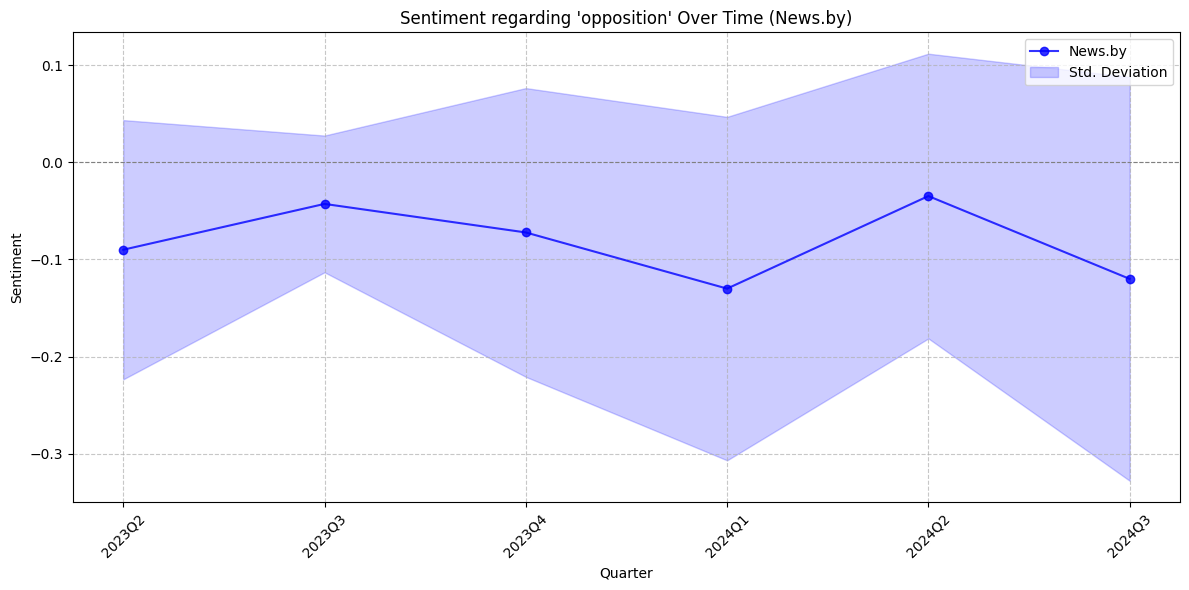

In [59]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract the sentiment data for "opposition"
opposition_bel = extract_entity_sentiment(bel_data, "opposition")
opposition_bel["Date"] = pd.to_datetime(opposition_bel["Date"])

opposition_bel["Quarter"] = opposition_bel["Date"].dt.to_period("Q").astype(str)   

# Group by Date to calculate the mean and standard deviation of sentiment
grouped = opposition_bel.groupby("Quarter")["Sentiment"]
mean_sentiment = grouped.mean().reset_index(name="MeanSentiment")
std_sentiment = grouped.std().reset_index(name="StdSentiment")

# Merge the mean and standard deviation DataFrames
sentiment_stats = pd.merge(mean_sentiment, std_sentiment, on="Quarter")
sentiment_stats = sentiment_stats.sort_values("Quarter")

# Create the plot with a shaded area representing the standard deviation
plt.figure(figsize=(12, 6))
plt.plot(sentiment_stats["Quarter"], sentiment_stats["MeanSentiment"],
         marker="o", linestyle="-", label="News.by", color="blue", alpha=0.8)

# Use fill_between to create a shaded area for mean ± standard deviation
plt.fill_between(sentiment_stats["Quarter"],
                 sentiment_stats["MeanSentiment"] - sentiment_stats["StdSentiment"],
                 sentiment_stats["MeanSentiment"] + sentiment_stats["StdSentiment"],
                 color="blue", alpha=0.2, label="Std. Deviation")

# Add a horizontal reference line at 0
plt.axhline(y=0, color="gray", linestyle="--", linewidth=0.8)

# Formatting the plot
plt.xlabel("Quarter")
plt.ylabel("Sentiment")
plt.title("Sentiment regarding 'opposition' Over Time (News.by)")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig("opposition_entity_quarter.png", dpi=300, bbox_inches='tight')
plt.show()

In [52]:
opposition_counts = count_entities(bel_data, ["opposition"])
print(f"Counts of 'opposition' in the News.by dataset: {opposition_counts}")

Counts of 'opposition' in the News.by dataset: Counter({'opposition': 146})


## Analysing entity-based sentiments within Russian War topic

In [47]:
russian_war_bel = bel_data[bel_data["Group"] == "Belarusian opposition"]
russian_war_bbc = bbc_data[bbc_data["Group"] == "Russian War on Ukraine"]

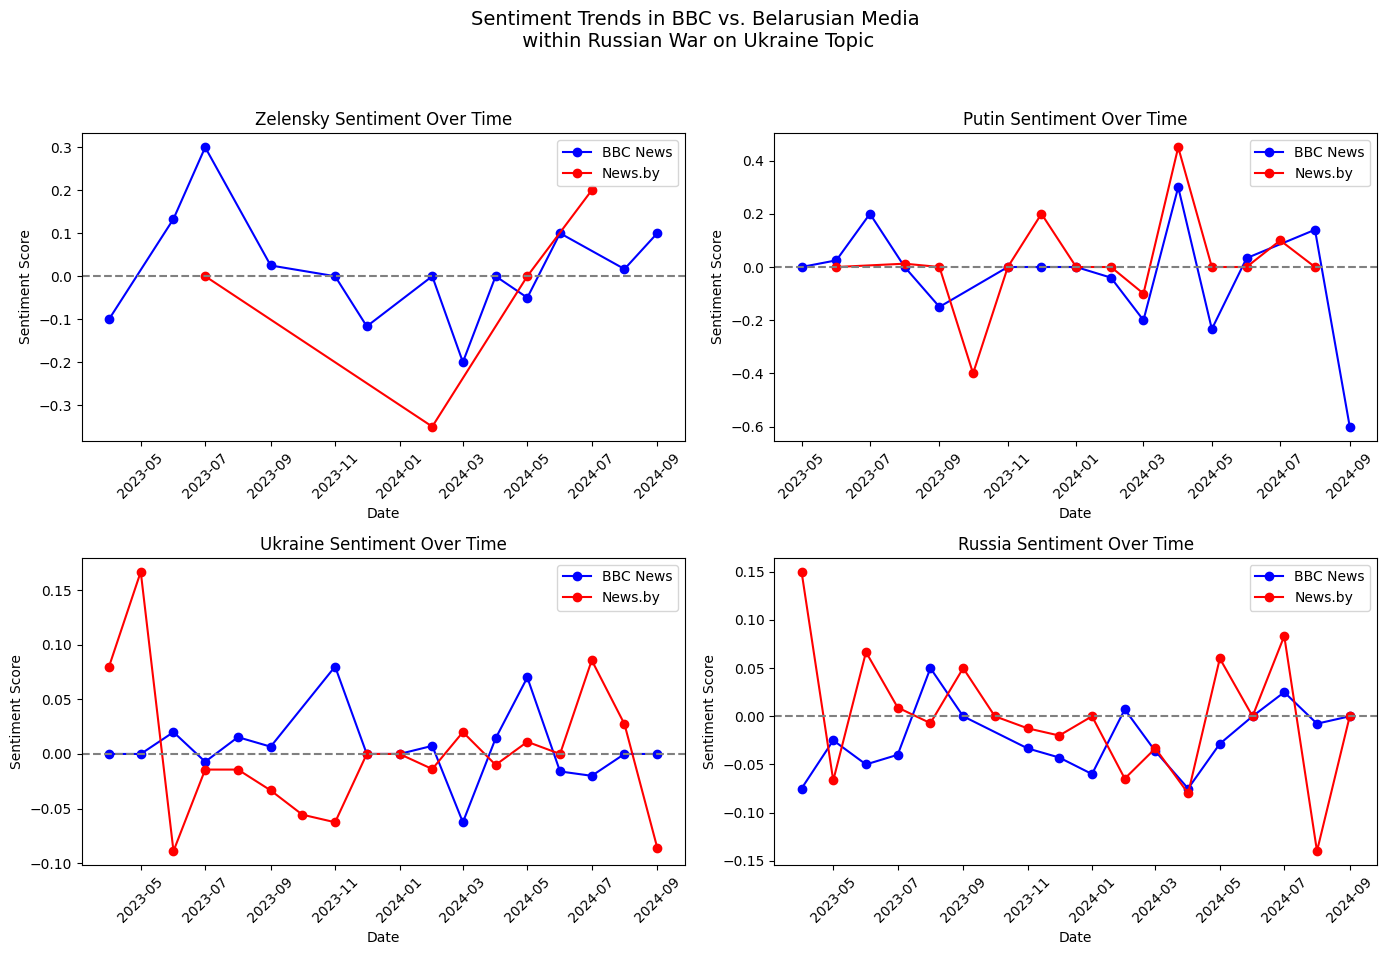

In [65]:
# Extract sentiment for each entity in both datasets
zelensky_bbc = extract_entity_sentiment(russian_war_bbc, "Zelensky")
zelensky_belarus = extract_entity_sentiment(russian_war_bel, "Nazis")
# Extract sentiment for each entity from both datasets using the extract_entity_sentiment function.
zelensky_bbc = extract_entity_sentiment(russian_war_bbc, "Zelensky")
zelensky_belarus = extract_entity_sentiment(russian_war_bel, "Nazis")

putin_bbc = extract_entity_sentiment(russian_war_bbc, "Putin")
putin_belarus = extract_entity_sentiment(russian_war_bel, "Putin")

ukraine_bbc = extract_entity_sentiment(russian_war_bbc, "Ukraine")
ukraine_belarus = extract_entity_sentiment(russian_war_bel, "Ukraine")

russia_bbc = extract_entity_sentiment(russian_war_bbc, "Russia")
russia_belarus = extract_entity_sentiment(russian_war_bel, "Russia")

def preprocess_sentiment(df):
    """
    Convert date strings to datetime objects, sort the dataframe by date, 
    drop any rows with invalid dates, and compute the average sentiment per date.
    
    Parameters:
        df (pandas.DataFrame): DataFrame containing at least "Date" and "Sentiment" columns.
    
    Returns:
        pandas.DataFrame: Grouped DataFrame with the mean sentiment for each valid date.
    """
    # Convert "Date" column to datetime, coercing errors to NaT
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    # Remove rows with invalid dates
    df = df.dropna(subset=["Date"])
    # Sort by date
    df = df.sort_values("Date")
    # Group by date and compute the mean sentiment score
    return df.groupby("Date", as_index=False)["Sentiment"].mean()

# Preprocess sentiment data for each entity and source
zelensky_bbc = preprocess_sentiment(zelensky_bbc)
zelensky_belarus = preprocess_sentiment(zelensky_belarus)
putin_bbc = preprocess_sentiment(putin_bbc)
putin_belarus = preprocess_sentiment(putin_belarus)
ukraine_bbc = preprocess_sentiment(ukraine_bbc)
ukraine_belarus = preprocess_sentiment(ukraine_belarus)
russia_bbc = preprocess_sentiment(russia_bbc)
russia_belarus = preprocess_sentiment(russia_belarus)

# Set up a 2x2 subplot grid for plotting sentiment trends
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Sentiment Trends in BBC vs. Belarusian Media\nwithin Russian War on Ukraine Topic", fontsize=14)

def plot_sentiment(ax, bbc_df, belarus_df, title):
    """
    Plot sentiment scores over time for two datasets on a given subplot axis.
    
    Parameters:
        ax (matplotlib.axes.Axes): The subplot axis to plot on.
        bbc_df (pandas.DataFrame): DataFrame with BBC sentiment data (must include 'Date' and 'Sentiment').
        belarus_df (pandas.DataFrame): DataFrame with Belarusian sentiment data (must include 'Date' and 'Sentiment').
        title (str): Title for the subplot.
    """
    # Plot sentiment trends for BBC
    ax.plot(bbc_df["Date"], bbc_df["Sentiment"], label="BBC News", color="blue", linestyle="-", marker="o")
    # Plot sentiment trends for Belarusian media (News.by)
    ax.plot(belarus_df["Date"], belarus_df["Sentiment"], label="News.by", color="red", linestyle="-", marker="o")
    # Add a horizontal line at 0 to indicate neutral sentiment
    ax.axhline(y=0, color="gray", linestyle="--")
    # Set subplot title and labels
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Sentiment Score")
    ax.legend()
    # Rotate x-axis labels for better readability
    ax.tick_params(axis="x", rotation=45)

# Plot sentiment trends for each entity in separate subplots
plot_sentiment(axes[0, 0], zelensky_bbc, zelensky_belarus, "Zelensky Sentiment Over Time")
plot_sentiment(axes[0, 1], putin_bbc, putin_belarus, "Putin Sentiment Over Time")
plot_sentiment(axes[1, 0], ukraine_bbc, ukraine_belarus, "Ukraine Sentiment Over Time")
plot_sentiment(axes[1, 1], russia_bbc, russia_belarus, "Russia Sentiment Over Time")

# Adjust layout to prevent overlap and ensure a neat presentation
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Save the resulting figure as a high-resolution image
plt.savefig("topics_entity.png", dpi=300, bbox_inches='tight')
# Display the plots
plt.show()